# Flash Point Fire Rescue: Actividad Integradora

Hecho por:
- Daniel Contreras Chávez A01710608
- Daniel Queijeiro Albo A01710441

In [17]:
# %pip install mesa seaborn --quiet

In [18]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import random
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import numpy as np
import pandas as pd
import copy

In [19]:
def get_distance(pos1, pos2):
    x = pos1[0] - pos2[0]
    y = pos1[1] - pos2[1]
    d = np.sqrt(x**2 + y**2)
    return d

def find_door(current_pos, next_pos, doors):
    for door in doors:
        if ((door['row1'], door['col1']) == current_pos and (door['row2'], door['col2']) == next_pos) or \
           ((door['row2'], door['col2']) == current_pos and (door['row1'], door['col1']) == next_pos):
            return door
    return None

def can_move(current_pos, next_pos, walls_grid, doors):
    current_row, current_col = current_pos
    next_row, next_col = next_pos

    delta_row = next_row - current_row
    delta_col = next_col - current_col

    # Validar que el movimiento es adyacente (no diagonal)
    if (delta_row, delta_col) not in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        return False

    walls = walls_grid[current_row][current_col].zfill(4)  # Asegura que tiene 4 caracteres

    # Determinar la dirección del movimiento
    if delta_row == -1 and delta_col == 0:  # Arriba
        wall_index = 0
    elif delta_row == 0 and delta_col == 1:  # Derecha
        wall_index = 1
    elif delta_row == 1 and delta_col == 0:  # Abajo
        wall_index = 2
    elif delta_row == 0 and delta_col == -1:  # Izquierda
        wall_index = 3
    else:
        return False

    if walls[wall_index] == "1":
        # Buscar si hay una puerta entre current_pos y next_pos
        door = find_door(current_pos, next_pos, doors)
        if door:
            return door['is_open']
        else:
            return False
    else:
        return True  # No hay pared en esa dirección

def is_border_position(pos, width, height):
    row, col = pos
    return row == 0 or row == height - 1 or col == 0 or col == width - 1


In [20]:
class FireFighterAgent(Agent):
    def __init__(self, id, model, ap=4):
        super().__init__(id, model)
        self.ap = ap
        self.is_carrying = False
        self.target_entrance = None
        self.path_to_exit = []
        self.assigned_POI = None

    def step(self):
        if self.ap <= 0:
            return

        if self.is_carrying:
            if self.target_entrance is None:
                self.get_nearest_entrance()
            self.rescue_victim()
        else:
            if self.assigned_POI is None:
                self.model.assign_POI(self)

            if self.assigned_POI:
                self.move_towards_poi()
            else:
                action_taken = self.extinguish_fire_or_smoke()
                if not action_taken:
                    self.move_randomly()

    
    def move_towards_poi(self):
        if self.pos == self.assigned_POI:
            self.interact_with_poi()
            return

        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        current_distance = get_distance(self.pos, self.assigned_POI)
        moved = False

        for position in possible_positions:
            can_move, door = self.can_move(self.pos, position, self.model.walls_grid, self.model.doors)
            new_distance = get_distance(position, self.assigned_POI)

            if can_move and new_distance < current_distance:
                self.model.grid.move_agent(self, position)
                self.ap -= 1
                moved = True
                break

            if door and not door['is_open'] and self.ap >= 1:
                door['is_open'] = True
                self.ap -= 1
                self.model.grid.move_agent(self, position)
                moved = True
                break

            if not can_move and self.ap >= 1:
                wall_key = self.get_wall_key(self.pos, position)
                if wall_key and wall_key in self.model.wall_damage:
                    self.damage_wall(wall_key, position, new_distance, current_distance)
                    moved = True
                    break

        if not moved:
            self.move_randomly()

    def get_wall_key(self, current_pos, next_pos):
        direction_map = {(-1, 0): 'N', (0, 1): 'E', (1, 0): 'S', (0, -1): 'W'}
        delta = (next_pos[0] - current_pos[0], next_pos[1] - current_pos[1])
        if delta in direction_map:
            direction = direction_map[delta]
            return (current_pos, direction)
        return None

    def damage_wall(self, wall_key, next_pos, new_distance, current_distance):
        if wall_key in self.model.wall_damage:
            self.model.wall_damage[wall_key] += 1

            if self.model.wall_damage[wall_key] >= 2:
                current_pos, direction = wall_key
                adjacent_direction = {'N': 'S', 'E': 'W', 'S': 'N', 'W': 'E'}
                if not self.model.is_within_bounds(next_pos):
                    return
                self.model.destroy_wall(
                    current_pos, direction, next_pos, adjacent_direction[direction]
                )
                self.model.total_damage += 2
                if new_distance < current_distance:
                    self.model.grid.move_agent(self, next_pos)
                    self.ap -= 1

        else:
            self.model.wall_damage[wall_key] = 1
            self.ap -= 1


    def get_nearest_entrance(self):
        min_distance = float('inf')
        closest_entrance = None

        for entrance in self.model.entrances:
            entrance_pos = (entrance['row'], entrance['col'])
            distance = get_distance(self.pos, entrance_pos)
            if distance < min_distance:
                min_distance = distance
                closest_entrance = entrance_pos

        if closest_entrance:
            self.target_entrance = closest_entrance

    def release_victim(self):
        """Libera la víctima en el borde."""
        self.is_carrying = False
        self.target_entrance = None
        self.model.rescued_victims += 1      
    def rescue_victim(self):
        if not self.is_carrying:
            return

        # Verificar si ya está en el borde del mapa (puede liberar a la víctima)
        if not self.is_carrying:
            return

        # Verificar si ya está en el borde del mapa
        if is_border_position(self.pos, self.model.width, self.model.height):
            # Comprobar si la pared en el borde está destruida
            row, col = self.pos
            walls = self.model.walls_grid[row][col].zfill(4)

            # Identificar la dirección del borde
            if row == 0 and walls[0] == '0':  # Borde superior, sin pared
                self.release_victim()
                return
            elif col == self.model.width - 1 and walls[1] == '0':  # Borde derecho, sin pared
                self.release_victim()
                return
            elif row == self.model.height - 1 and walls[2] == '0':  # Borde inferior, sin pared
                self.release_victim()
                return
            elif col == 0 and walls[3] == '0':  # Borde izquierdo, sin pared
                self.release_victim()
                return

        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        possible_positions = list(possible_positions)
        np.random.shuffle(possible_positions)

        current_distance = get_distance(self.pos, self.target_entrance) if self.target_entrance else float('inf')
        moved = False

        for position in possible_positions:
            if is_border_position(position, self.model.width, self.model.height):
                # Verificar si hay una pared entre la posición actual y la posición objetivo
                delta_row, delta_col = position[0] - self.pos[0], position[1] - self.pos[1]
                direction = None
                if delta_row == -1 and delta_col == 0:
                    direction = 'N'
                elif delta_row == 1 and delta_col == 0:
                    direction = 'S'
                elif delta_row == 0 and delta_col == -1:
                    direction = 'W'
                elif delta_row == 0 and delta_col == 1:
                    direction = 'E'

                wall_key = (self.pos, direction)

                if direction and wall_key in self.model.wall_damage:
                    self.model.wall_damage[wall_key] += 1

                    if self.model.wall_damage[wall_key] >= 2:
                        # Destruir la pared del borde y mover al agente
                        adjacent_direction = {'N': 'S', 'E': 'W', 'S': 'N', 'W': 'E'}
                        self.model.destroy_wall(self.pos, direction, position, adjacent_direction[direction])
                        self.model.total_damage += 2
                        self.model.grid.move_agent(self, position)
                        self.ap -= 2
                        moved = True
                        break
                else:
                    self.model.wall_damage[wall_key] = 1
                    self.ap -= 1
                    break

        # Si no logró romper una pared del borde, intentar moverse hacia la entrada
        if not moved:
            for position in possible_positions:
                can_move, _ = self.can_move(self.pos, position, self.model.walls_grid, self.model.doors)
                if can_move:
                    new_distance = get_distance(position, self.target_entrance) if self.target_entrance else float('inf')
                    if new_distance < current_distance:
                        self.model.grid.move_agent(self, position)
                        self.ap -= 2
                        moved = True
                        break

    
    def interact_with_poi(self):
        for marker in self.model.markers:
            if marker['row'] == self.assigned_POI[0] and marker['col'] == self.assigned_POI[1]:
                marker['revealed'] = True
                if marker['type'] == 'v':
                    self.is_carrying = True
                elif marker['type'] == 'f':
                    self.model.markers.remove(marker)
                break

        if self.assigned_POI in self.model.assigned_POIs:
            self.model.assigned_POIs.remove(self.assigned_POI)
        self.assigned_POI = None

    def move_randomly(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        possible_positions = list(possible_positions)
        np.random.shuffle(possible_positions) 

        for position in possible_positions:
            can_move, door = self.can_move(self.pos, position, self.model.walls_grid, self.model.doors)
            if can_move:
                self.model.grid.move_agent(self, position)
                self.ap -= 1
                break
            elif door is not None:
                if self.ap >= 1:
                    door['is_open'] = True 
                    self.model.grid.move_agent(self, position)
                    self.ap -= 1
                    break
                else:
                    continue

    def can_move(self, current_pos, next_pos, walls_grid, doors):
        current_row, current_col = current_pos
        next_row, next_col = next_pos

        delta_row = next_row - current_row
        delta_col = next_col - current_col

        walls = walls_grid[current_row][current_col].zfill(4)

        if delta_row == -1 and delta_col == 0:
            wall_index = 0
        elif delta_row == 0 and delta_col == 1:
            wall_index = 1
        elif delta_row == 1 and delta_col == 0:
            wall_index = 2
        elif delta_row == 0 and delta_col == -1:
            wall_index = 3
        else:
            return False, None

        if walls[wall_index] == "1":
            # Buscar si hay una puerta entre current_pos y next_pos
            door = self.find_door(current_pos, next_pos, doors)
            if door:
                if door['is_open']:
                    return True, door
                else:
                    return False, door
            else:
                return False, None  # Pared sin puerta
        else:
            return True, None  # No hay pared en esa dirección

    def find_door(self, current_pos, next_pos, doors):
        for door in doors:
            if ((door['row1'], door['col1']) == current_pos and (door['row2'], door['col2']) == next_pos) or \
               ((door['row2'], door['col2']) == current_pos and (door['row1'], door['col1']) == next_pos):
                return door
        return None

    def extinguish_fire_or_smoke(self):
        positions_to_check = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=True)

        for position in positions_to_check:
            # Extinguir completamente el fuego
            if position in self.model.fire_positions and self.ap >= 2:
                self.model.fire_positions.remove(position)
                self.ap -= 2
                return True

        for position in positions_to_check:
            # Convertir fuego en humo 
            if position in self.model.fire_positions and self.ap >= 1:
                self.model.fire_positions.remove(position)
                self.model.smoke_positions.append(position)
                self.ap -= 1
                return True

        for position in positions_to_check:
            # Extinguir humo
            if position in self.model.smoke_positions and self.ap >= 1:
                self.model.smoke_positions.remove(position)
                self.ap -= 1
                return True

        return False


In [21]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    for agent in model.schedule.agents:
        x, y = agent.pos
        grid[x][y] = 2

    return grid

def get_doors_state(model):
    return copy.deepcopy(model.doors)

def get_poi(model):
    return tuple((marker['row'], marker['col'], marker['type'], marker['revealed']) for marker in model.markers)

def get_fires_state(model):
    return [
        {"row": pos[0], "col": pos[1]}
        for pos in model.fire_positions
    ]

def get_smokes_state(model):
    return [
        {"row": pos[0], "col": pos[1]}
        for pos in model.smoke_positions
    ]

def get_walls_state(model):
    return copy.deepcopy(model.walls_grid)




In [22]:
class BoardModel(Model):
    def __init__(self, width, height, walls, doors, entrances, markers, fire_markers):
        super().__init__()
        self.width = width
        self.height = height
        self.walls_grid = walls
        self.doors = doors
        self.entrances = entrances
        self.markers = markers
        self.running = True
        self.fire_positions = []
        self.smoke_positions = []
        self.total_damage = 0
        self.victory_condition_met = False
        self.aux = 0
        self.rescued_victims = 0
        self.assigned_POIs = []
        self.grid = MultiGrid(width, height, True)
        self.schedule = SimultaneousActivation(self)
        self.steps = 0
        self.current_agent_index = 0
        self.datacollector = DataCollector(
            model_reporters={
                "Grid": get_grid,
                "Doors": get_doors_state,
                "POI": get_poi,
                "Fires": get_fires_state,
                "Smokes": get_smokes_state,
                "Walls": get_walls_state,
                "rescued_victims": lambda model: model.rescued_victims,
                "total_damage": lambda model: model.total_damage,
                "Steps": lambda model: model.steps,
            },
        )

        # Inicializar el diccionario para rastrear el daño de las paredes
        self.wall_damage = {}
        for row in range(self.width):
            for col in range(self.height):
                walls = self.walls_grid[row][col]
                directions = ['N', 'E', 'S', 'W']
                for idx, direction in enumerate(directions):
                    if walls[idx] == '1':
                        self.wall_damage[((row, col), direction)] = 0  # Daño inicial: 0
        

        # Crear todos los agentes y agregarlos a la lista de agentes por añadir
        self.agents_to_add = []
        for i in range(6):
            agent = FireFighterAgent(i, self)
            self.agents_to_add.append(agent)

        # Inicializar posiciones de fuego
        for fire in fire_markers:
            position = (fire['row'], fire['col'])
            if 0 <= position[0] < self.height and 0 <= position[1] < self.width:
                self.fire_positions.append(position)
    
    def assign_POI(self, agent):
        available_POIs = [
            (marker['row'], marker['col'])
            for marker in self.markers
            if not marker['revealed'] and (marker['row'], marker['col']) not in self.assigned_POIs
        ]

        if not available_POIs:
            return None  # No hay POIs disponibles

        # Encontrar el POI más cercano
        closest_POI = min(
            available_POIs,
            key=lambda poi: get_distance(agent.pos, poi)
        )

        # Asignar el POI al agente
        self.assigned_POIs.append(closest_POI)
        agent.assigned_POI = closest_POI

        return closest_POI
    
    def add_smoke(self):
        random_row = random.randint(0, self.width - 1)
        random_col = random.randint(0, self.height - 1)
        random_pos = (random_row, random_col)
        if not self.is_within_bounds(random_pos):
            return

        # 1. Verificar si el humo se añade en una posición con fuego
        if random_pos in self.fire_positions:
            self.handle_explosion(random_pos)
            return

        # 2. Verificar si ya hay un humo en esa posición
        if random_pos in self.smoke_positions:
            # Eliminar el humo existente
            self.smoke_positions.remove(random_pos)
            # Añadir fuego en esta posición
            self.fire_positions.append(random_pos)
            return

        # 3. Verificar si la posición está adyacente a algún fuego con conexión válida
        adjacent_positions = self.get_adjacent_positions(random_pos)
        for adj in adjacent_positions:
            if not self.is_within_bounds(adj):
                continue
            if adj in self.fire_positions:
                # Verificar si hay una pared o una puerta cerrada entre random_pos y adj
                can_comm = can_move(random_pos, adj, self.walls_grid, self.doors)
                if can_comm:
                    # Añadir fuego en esta posición
                    self.fire_positions.append(random_pos)
                    return

        # 4. Si ninguna de las condiciones anteriores se cumple, añadir el humo
        self.smoke_positions.append(random_pos)

    def get_adjacent_positions(self, pos):
        row, col = pos
        adjacent = []
        
        if row > 0:
            adjacent.append((row - 1, col))
        if row < self.height - 1:
            adjacent.append((row + 1, col))
        if col > 0:
            adjacent.append((row, col - 1))
        if col < self.width - 1:
            adjacent.append((row, col + 1))
        
        return adjacent

    def handle_explosion(self, pos):
        directions = [(-1, 0, 'N', 'S'), (1, 0, 'S', 'N'), (0, -1, 'W', 'E'), (0, 1, 'E', 'W')]

        for d_row, d_col, dir_current, dir_adjacent in directions:
            next_pos = (pos[0] + d_row, pos[1] + d_col)

            if not self.is_within_bounds(next_pos):
                continue

            # Si hay una pared o puerta, dañarla
            if not can_move(pos, next_pos, self.walls_grid, self.doors):
                wall_key = ((pos[0], pos[1]), dir_current)
                if wall_key in self.wall_damage:
                    self.wall_damage[wall_key] += 1
                    if self.wall_damage[wall_key] >= 2:
                        self.destroy_wall(pos, dir_current, next_pos, dir_adjacent)
                        self.total_damage += 2
                else:
                    door = find_door(pos, next_pos, self.doors)
                    if door and not door['is_open']:
                        self.destroy_door(door)
                        self.total_damage += 1
                continue

            # Propagar fuego a una celda válida
            if next_pos in self.smoke_positions:
                self.smoke_positions.remove(next_pos)
                self.fire_positions.append(next_pos)
            elif next_pos in self.fire_positions:
                # propagar fuego en línea recta
                self.propagate_shockwave(next_pos, d_row, d_col, dir_current, dir_adjacent)
            else:
                # Propagar fuego a una celda vacía
                self.fire_positions.append(next_pos)

        self.process_fire_adjacent_smoke()
    
    def propagate_shockwave(self, start_pos, d_row, d_col, dir_current, dir_adjacent):
        current_pos = start_pos

        while True:
            next_pos = (current_pos[0] + d_row, current_pos[1] + d_col)

            if not self.is_within_bounds(next_pos):
                break

            # Verificar si hay una puerta o pared bloqueando
            if not can_move(current_pos, next_pos, self.walls_grid, self.doors):
                # Daño a la pared, si aplica
                wall_key = ((current_pos[0], current_pos[1]), dir_current)
                if wall_key in self.wall_damage:
                    self.wall_damage[wall_key] += 1
                    if self.wall_damage[wall_key] >= 2:
                        self.destroy_wall(current_pos, dir_current, next_pos, dir_adjacent)
                        self.total_damage += 2
                else:
                    door = find_door(current_pos, next_pos, self.doors)
                    if door and not door['is_open']:
                        self.destroy_door(door)
                        self.total_damage += 1
                break

            if next_pos in self.fire_positions:
                # Continuar propagación si ya hay fuego
                current_pos = next_pos
                continue

            if next_pos in self.smoke_positions:
                # Convertir humo en fuego y continuar
                self.smoke_positions.remove(next_pos)
                self.fire_positions.append(next_pos)
                current_pos = next_pos
            else:
                # Propagar fuego a celda vacía y detener
                self.fire_positions.append(next_pos)
                break

    def destroy_door(self, door):
        door['is_open'] = True


    def destroy_wall(self, current_pos, dir_current, adjacent_pos, dir_adjacent):
        if not self.is_within_bounds(current_pos) or not self.is_within_bounds(adjacent_pos):
            return
        direction_map = {'N': 0, 'E': 1, 'S': 2, 'W': 3}  # Mapear dirección a índice de paredes
        current_row, current_col = current_pos
        adj_row, adj_col = adjacent_pos


        if not self.is_within_bounds((current_row, current_col)):
            return
        if not self.is_within_bounds((adj_row, adj_col)):
            return

        # Convertir las paredes en '0' en ambas celdas
        walls_current = list(self.walls_grid[current_row][current_col])
        walls_adjacent = list(self.walls_grid[adj_row][adj_col])

        walls_current[direction_map[dir_current]] = '0'
        walls_adjacent[direction_map[dir_adjacent]] = '0'

        self.walls_grid[current_row][current_col] = ''.join(walls_current)
        self.walls_grid[adj_row][adj_col] = ''.join(walls_adjacent)

    def is_within_bounds(self, pos):
        row, col = pos
        return 0 <= row < self.width and 0 <= col < self.height

    def process_fire_adjacent_smoke(self):
        conversion_occurred = True 
        
        while conversion_occurred:
            conversion_occurred = False
            # Copia de la lista actual de fuegos para evitar modificar la lista mientras se itera
            current_fires = copy.deepcopy(self.fire_positions)
            
            for fire_pos in current_fires:
                adjacent_positions = self.get_adjacent_positions(fire_pos)
                
                for adj in adjacent_positions:
                    if adj in self.smoke_positions:
                        # Verificar si hay una pared o una puerta cerrada entre fire_pos y adj
                        if can_move(fire_pos, adj, self.walls_grid, self.doors):
                            # Convertir humo en fuego
                            self.smoke_positions.remove(adj)
                            self.fire_positions.append(adj)
                            conversion_occurred = True
            # Si en una iteración no se convirtió ningún humo, se detiene el bucle

    def check_termination_conditions(self):
        if self.rescued_victims >= 7:
            return True
        elif self.total_damage >= 24:
            return True
        return False

    def step(self):
        if not self.check_termination_conditions():
            # Verificar si aún hay agentes por añadir y si el agente actual ha terminado su turno
            if self.current_agent_index < len(self.agents_to_add):
                # Verificar si el agente actual ya está en el scheduler
                if self.current_agent_index >= len(self.schedule.agents):
                    # Obtener el siguiente agente a añadir
                    agent_to_add = self.agents_to_add[self.current_agent_index]

                    entrance = self.entrances[self.aux]
                    entrance_pos = (entrance['row'], entrance['col'])

                    # Validar que la posición de la entrada esté dentro de los límites del grid
                    if 0 <= entrance_pos[0] < self.width and 0 <= entrance_pos[1] < self.height:
                        self.grid.place_agent(agent_to_add, entrance_pos)
                        self.schedule.add(agent_to_add)

            # Verificar si hay un agente activo
            if self.current_agent_index < len(self.schedule.agents):
                # Obtener el agente actual
                current_agent = self.schedule.agents[self.current_agent_index]

                # Verificar si el agente tiene AP disponible
                if current_agent.ap > 0:
                    # El agente realiza una acción
                    current_agent.step()
                else:
                    self.add_smoke()
                    current_agent.ap = 4
                    # Pasar al siguiente agente
                    if self.current_agent_index < 5:
                        self.current_agent_index += 1
                    else:
                        self.current_agent_index = 0
                    if self.aux < 3:
                        self.aux += 1
                    else:
                        self.aux = 0

                    # Revisar y rellenar POIs si es necesario
                    self.fill_pois()

            self.steps += 1
        else: 
            self.running = False
            return
        self.datacollector.collect(self)

    def fill_pois(self):
        # Contar los POIs activos y agentes que están cargando víctimas
        active_pois = [
            (marker['row'], marker['col'])
            for marker in self.markers
            if not marker['revealed']
        ]
        active_pois += [
            agent.pos
            for agent in self.schedule.agents
            if isinstance(agent, FireFighterAgent) and agent.is_carrying
        ]

        # Si hay menos de 3, rellenar con nuevos POIs
        while len(active_pois) < 3:
            new_poi = self.generate_random_poi()
            if new_poi:
                # Si hay un agente en la posición del POI, revelar el POI de inmediato
                if any(agent.pos == (new_poi['row'], new_poi['col']) for agent in self.schedule.agents):
                    if new_poi['type'] == 'f':  # Falsa alarma
                        continue  # No se añade al mapa
                    else:
                        # Si es una víctima, se considera parte de los POIs activos
                        active_pois.append((new_poi['row'], new_poi['col']))
                else:
                    self.markers.append(new_poi)
                    active_pois.append((new_poi['row'], new_poi['col']))

    def generate_random_poi(self):
        max_attempts = 100
        for _ in range(max_attempts):
            random_row = random.randint(0, self.width - 1)
            random_col = random.randint(0, self.height - 1)

            # Verificar que la posición no esté ocupada por otro POI
            if any(
                random_row == marker['row'] and random_col == marker['col']
                for marker in self.markers if not marker['revealed']
            ):
                continue  # La posición ya tiene un POI

            # Si hay fuego o humo en la posición, eliminarlo
            if (random_row, random_col) in self.fire_positions:
                self.fire_positions.remove((random_row, random_col))
            elif (random_row, random_col) in self.smoke_positions:
                self.smoke_positions.remove((random_row, random_col))
            
            # Crear un nuevo POI
            return {
                'row': random_row,
                'col': random_col,
                'type': random.choices(['v', 'f'], weights=[0.6, 0.4])[0],  # 40% real, 60% false
                'revealed': False
            }

        return None



In [23]:
def parse_file(filename):
    walls_grid = []
    markers = []
    fire_markers = []
    doors = []
    entrances = []
    with open(filename, 'r') as file:
        # Leer las primeras 6 líneas para el grid
        for _ in range(6):
            line = file.readline().strip()
            walls = line.split()
            walls_grid.append(walls)
        # Leer los marcadores de POI
        for _ in range(3):
            line = file.readline().strip()
            if line:
                row, col, marker_type = line.split()
                markers.append({'row': int(row) - 1, 'col': int(col) - 1, 'type': marker_type, 'revealed': False})

        # Leer los marcadores de fuego
        for _ in range(10):
            line = file.readline().strip()
            if line:
                row, col = line.split()
                fire_markers.append({'row': int(row) - 1, 'col': int(col) - 1})
        # Leer las puertas
        for _ in range(8):
            line = file.readline().strip()
            if line:
                row1, col1, row2, col2 = line.split()
                doors.append({
                    'row1': int(row1) - 1,
                    'col1': int(col1) - 1,
                    'row2': int(row2) - 1,
                    'col2': int(col2) - 1,
                    'is_open': False  # Por defecto, las puertas están cerradas
                })
        # Leer las entradas
        for _ in range(4):
            line = file.readline().strip()
            if line:
                row, col = line.split()
                entrances.append({'row': int(row) - 1, 'col': int(col) - 1})
    return walls_grid, markers, fire_markers, doors, entrances


In [24]:
def draw_smoke(ax, smokes, num_rows):
    for smoke in smokes:
        row, col = smoke['row'], smoke['col']
        x, y = col, num_rows - row - 1  # Ajuste para coordenadas

        color = 'gray'
        marker_shape = 's'  # Cuadrado para representar el humo

        ax.scatter(x, y, marker=marker_shape, color=color, s=100)


In [25]:
def draw_fire(ax, fires, num_rows):
    for fire in fires:
        row, col = fire['row'], fire['col']
        x, y = col, num_rows - row - 1  # Ajuste para coordenadas

        color = 'red'
        marker_shape = '*'  # Forma de estrella para representar el fuego

        ax.scatter(x, y, marker=marker_shape, color=color, s=200)


In [26]:
def draw_poi(ax, markers, num_rows):
    for marker in markers:
        row, col, type_, revealed = marker
        x, y = col, num_rows - row - 1 # Ajuste para coordenadas

        if revealed:
            continue
        else:
            if not revealed:
                color = 'cyan'
                marker_shape = 'o'
            elif type_ == 'v':
                color = 'green'
                marker_shape = 'o'
            elif type_ == 'f':
                color = 'magenta'
                marker_shape = 'x'
        

        ax.scatter(x, y, marker=marker_shape, color=color, s=100)

In [27]:
def draw_walls(ax, walls_grid, door_dict, entrances):
    # Dentro de la función draw_walls o después de crear el subplot
    for spine in ax.spines.values():
        spine.set_visible(False)

    num_rows = len(walls_grid)
    num_cols = len(walls_grid[0])

    # Crear un conjunto de entradas para acceso rápido
    entrances_set = set((entry['col'], entry['row']) for entry in entrances)

    for row in range(num_rows):
        for col in range(num_cols):
            walls = walls_grid[row][col]
            x, y = col - 0.5, num_rows - row - 0.5  # Ajuste para coordenadas

            cell = (col, row)  # Coordenadas en orden (x, y)

            # Definir direcciones y ajustes
            directions = [
                ((0, -1), [x, x + 1], [y, y]),         # Pared superior
                ((1, 0),  [x + 1, x + 1], [y - 1, y]), # Pared derecha
                ((0, 1),  [x, x + 1], [y - 1, y - 1]), # Pared inferior
                ((-1, 0), [x, x], [y - 1, y])          # Pared izquierda
            ]

            for idx, ((dx, dy), x_coords, y_coords) in enumerate(directions):
                neighbor_col = col + dx
                neighbor_row = row + dy
                neighbor = (neighbor_col, neighbor_row)
                
                # Verificar si la pared existe
                if walls[idx] == "1":
                    # Verificar si es una pared en el borde
                    is_edge_wall = False
                    if neighbor_col < 0 or neighbor_col >= num_cols or neighbor_row < 0 or neighbor_row >= num_rows:
                        is_edge_wall = True

                    # Determinar el color de la pared
                    if is_edge_wall and cell in entrances_set:
                        # Pared perimetral con una entrada: dibujar en naranja
                        color = "orange"
                        linestyle = "-"
                    else:
                        # Pared normal o perimetral sin entrada
                        door = door_dict.get((cell, neighbor))
                        if door:
                            if door['is_open']:
                                color = "green"
                                linestyle = "--"
                            else:
                                color = "brown"
                                linestyle = "-"
                        else:
                            color = "black"
                            linestyle = "-"
                    
                    # Dibujar la pared con el color y estilo determinados
                    ax.plot(x_coords, y_coords, color=color, linestyle=linestyle, linewidth=2)
                else:
                    # No hay pared; no dibujamos nada
                    pass




In [28]:
WIDTH = 6
HEIGHT = 8

walls, markers, fire_markers, doors, entrances = parse_file("final.txt")
# Crear el diccionario de puertas
door_dict = {}
for door in doors:
    cell1 = (door['row1'], door['col1'])
    cell2 = (door['row2'], door['col2'])
    door_dict[(cell1, cell2)] = door
    door_dict[(cell2, cell1)] = door

model = BoardModel(WIDTH, HEIGHT, walls, doors, entrances, markers, fire_markers)
while not model.check_termination_conditions():
    model.step()

In [29]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head(5)

,Grid,Doors,POI,Fires,Smokes,Walls,rescued_victims,total_damage,Steps
0,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0], [0....","[{'row1': 0, 'col1': 2, 'row2': 0, 'col2': 3, ...","((1, 3, v, False), (4, 0, f, False), (4, 7, v,...","[{'row': 1, 'col': 1}, {'row': 1, 'col': 2}, {...",[],"[[1100, 1000, 1001, 1100, 1001, 1100, 1000, 10...",0,0,1
1,"[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0], [0....","[{'row1': 0, 'col1': 2, 'row2': 0, 'col2': 3, ...","((1, 3, v, False), (4, 0, f, False), (4, 7, v,...","[{'row': 1, 'col': 1}, {'row': 1, 'col': 2}, {...",[],"[[1100, 1000, 1001, 1100, 1001, 1100, 1000, 10...",0,0,2
2,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0], [0....","[{'row1': 0, 'col1': 2, 'row2': 0, 'col2': 3, ...","((1, 3, v, False), (4, 0, f, False), (4, 7, v,...","[{'row': 1, 'col': 1}, {'row': 1, 'col': 2}, {...",[],"[[1100, 1000, 1001, 1000, 1000, 1100, 1000, 10...",0,2,3
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[{'row1': 0, 'col1': 2, 'row2': 0, 'col2': 3, ...","((1, 3, v, False), (4, 0, f, False), (4, 7, v,...","[{'row': 1, 'col': 1}, {'row': 1, 'col': 2}, {...",[],"[[1100, 1000, 1001, 1000, 1000, 1100, 1000, 10...",0,2,4
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[{'row1': 0, 'col1': 2, 'row2': 0, 'col2': 3, ...","((1, 3, v, True), (4, 0, f, False), (4, 7, v, ...","[{'row': 1, 'col': 1}, {'row': 1, 'col': 2}, {...",[],"[[1100, 1000, 1001, 1000, 1000, 1100, 1000, 10...",0,2,5


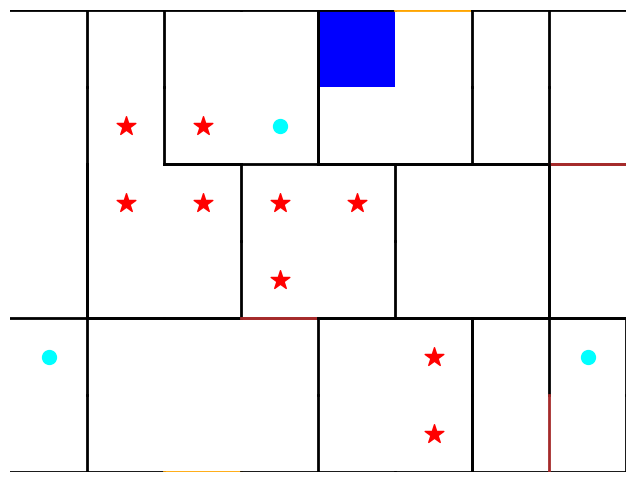

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
custom_cmap = ListedColormap(["white", "green", "blue"])

# Dibujar paredes
# Definir el 'extent' para alinear los bordes de los píxeles con las coordenadas
extent = [-0.5, len(walls[0]) - 0.5, -0.5, len(walls) - 0.5]

def animate(i):
    ax.clear()
    ax.set_xticks([])
    ax.set_yticks([])

    # Obtener el estado de las puertas en el paso actual
    doors_state = all_grids.iloc[i]["Doors"]

    # Crear el door_dict para el cuadro actual
    door_dict_current = {}
    for door in doors_state:
        cell1 = (door['col1'], door['row1'])
        cell2 = (door['col2'], door['row2'])
        door_dict_current[(cell1, cell2)] = door
        door_dict_current[(cell2, cell1)] = door

    # Obtener el estado de las paredes en el paso actual
    walls_state = all_grids.iloc[i]["Walls"]

    # Mostrar los agentes primero
    grid_state = all_grids.iloc[i]["Grid"]
    ax.imshow(grid_state, cmap=custom_cmap, interpolation="none", origin='upper', extent=extent)

    # Dibujar paredes y puertas con el estado actual, incluyendo las entradas
    draw_walls(ax, walls_state, door_dict_current, entrances)

    # Obtener el estado de los POIs en el paso actual
    poi_state = all_grids.iloc[i]["POI"]

    # Obtener el estado de los fuegos en el paso actual
    fire_state = all_grids.iloc[i]["Fires"]

    # Obtener el estado de los humos en el paso actual
    smoke_state = all_grids.iloc[i]["Smokes"]

    # Dibujar los POIs con colores según su estado y tipo
    num_rows = len(walls)  # Asumiendo que 'walls' es la lista de filas
    draw_poi(ax, poi_state, num_rows)

    # Dibujar los fuegos
    draw_fire(ax, fire_state, num_rows)

    # Dibujar los humos
    draw_smoke(ax, smoke_state, num_rows)


anim = animation.FuncAnimation(fig, animate, frames=model.steps)
anim

Outcome
Loss    72
Win     28
Name: count, dtype: int64


C:\Users\danyq\AppData\Local\Temp\ipykernel_18528\3900398732.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='pastel')


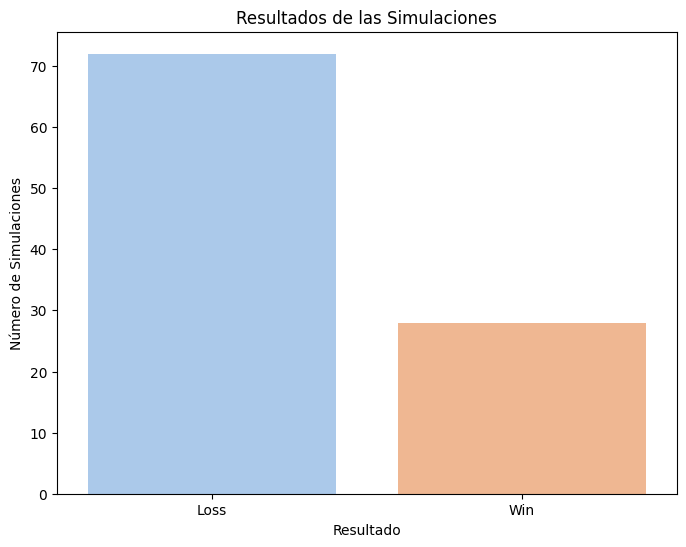

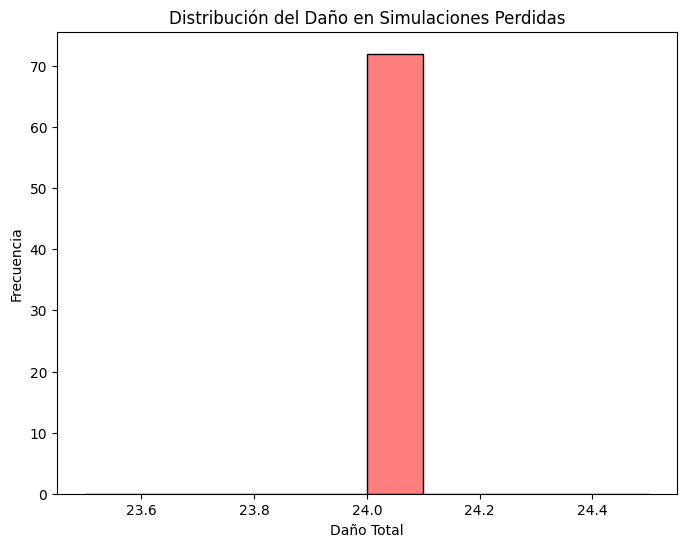

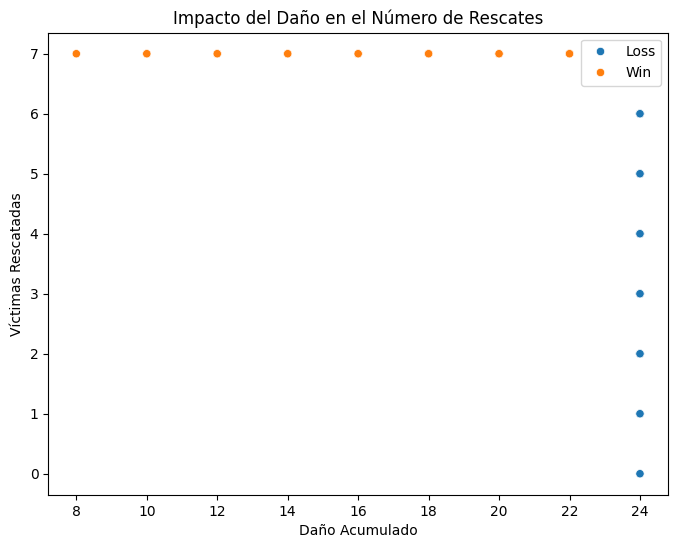

In [ ]:
walls, markers, fire_markers, doors, entrances = parse_file("final.txt")
def run_simulation(model_params, max_steps):
    # Inicializar el modelo con los parámetros dados
    model = BoardModel(**model_params)
    steps = 0

    # Ejecutar la simulación hasta que se cumplan las condiciones de término o se alcance max_steps
    while steps < max_steps and not model.check_termination_conditions():
        model.step()
        steps += 1

    # Recopilar los resultados deseados
    results = {
        "rescued_victims": model.rescued_victims,
        "total_damage": model.total_damage,
        "steps": steps,
        "victory": model.rescued_victims >= 7,  # Definir victoria o derrota
    }
    return results

# Define los parámetros iniciales del modelo
base_params = {
    "width": 6,
    "height": 8,
    "walls": walls,
    "doors": doors,
    "entrances": entrances,
    "markers": markers,
    "fire_markers": fire_markers,
}

# Configuración
num_simulations = 1000  # Número de simulaciones
max_steps = 600  # Máximo número de pasos por simulación

# Almacenar resultados
simulation_results = []

# Ejecutar las simulaciones
for i in range(num_simulations):
    result = run_simulation(base_params, max_steps)
    simulation_results.append(result)

# Convertir resultados a DataFrame
results_df = pd.DataFrame(simulation_results)

# Crear columna de "Resultado" (Win o Loss)
results_df['Outcome'] = results_df.apply(
    lambda row: 'Win' if row['victory'] else 'Loss', axis=1
)

# Contar resultados
outcome_counts = results_df['Outcome'].value_counts()
print(outcome_counts)

# 1. Gráfico de barras: Ganadas vs Perdidas
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette='pastel')
plt.title('Resultados de las Simulaciones')
plt.xlabel('Resultado')
plt.ylabel('Número de Simulaciones')
plt.xticks(rotation=0)
plt.show()

# 3. Distribución del daño acumulado en simulaciones perdidas
loss_damage = results_df[results_df['Outcome'] == 'Loss']['total_damage']
plt.figure(figsize=(8, 6))
sns.histplot(loss_damage, bins=10, kde=True, color="red")
plt.title('Distribución del Daño en Simulaciones Perdidas')
plt.xlabel('Daño Total')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='total_damage', y='rescued_victims', hue='Outcome')
plt.title('Impacto del Daño en el Número de Rescates')
plt.xlabel('Daño Acumulado')
plt.ylabel('Víctimas Rescatadas')
plt.legend()
plt.show()


C:\Users\danyq\AppData\Local\Temp\ipykernel_18528\3139525192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


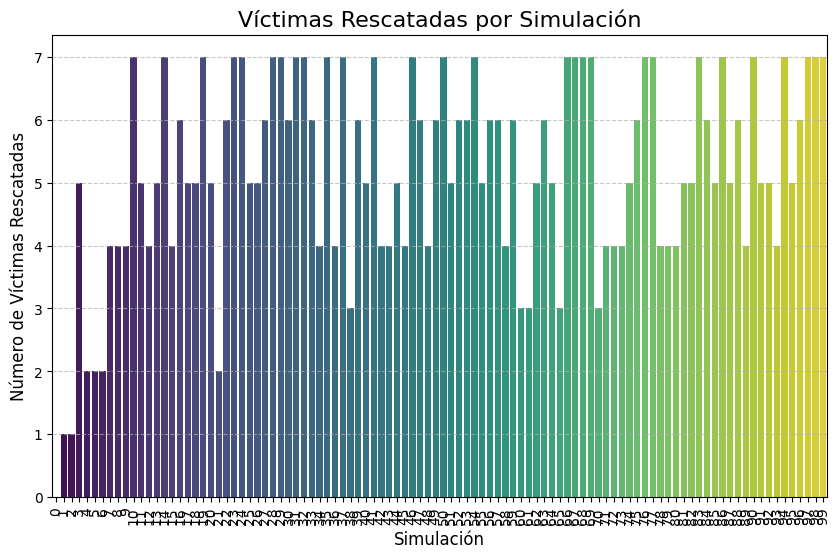

C:\Users\danyq\AppData\Local\Temp\ipykernel_18528\3139525192.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Outcome', y='steps', palette='Set2')


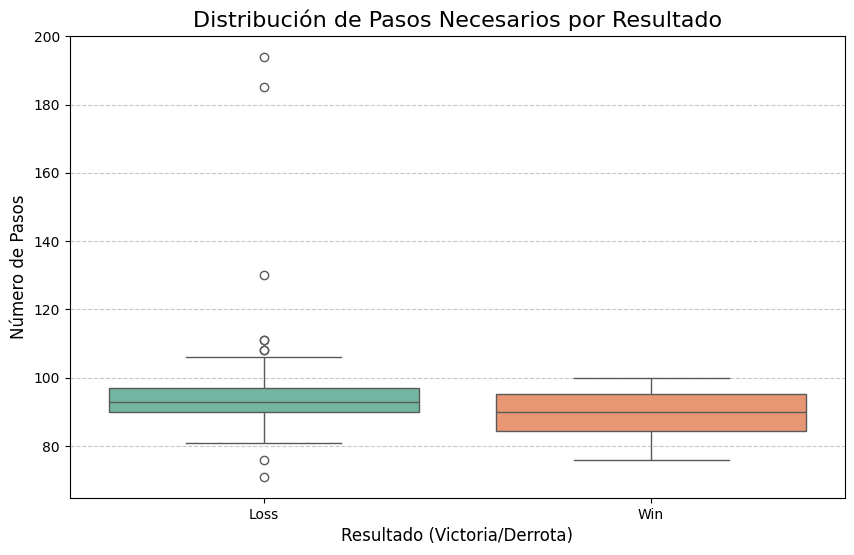

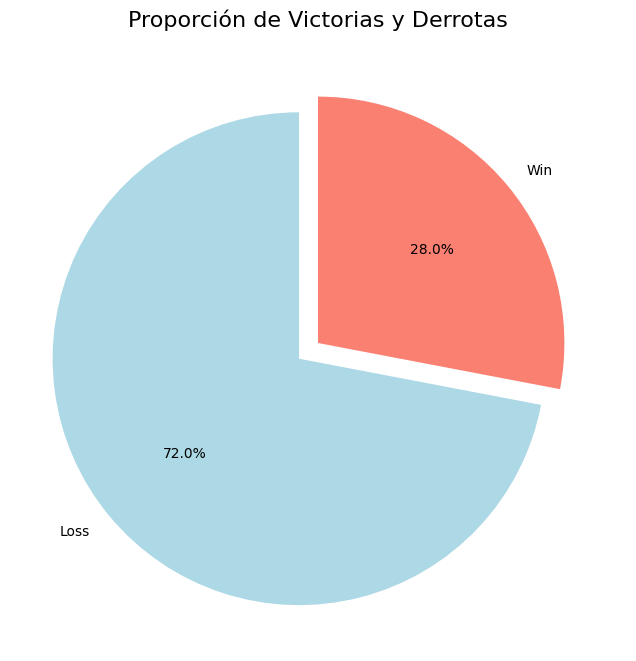

In [32]:
# Visualización de víctimas rescatadas por simulación

plt.figure(figsize=(10, 6))
sns.barplot(
    x=results_df.index,
    y=results_df['rescued_victims'],
    palette='viridis',
)
plt.title('Víctimas Rescatadas por Simulación', fontsize=16)
plt.xlabel('Simulación', fontsize=12)
plt.ylabel('Número de Víctimas Rescatadas', fontsize=12)
plt.xticks(rotation=90)  # Para rotar las etiquetas si son muchas simulaciones
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='Outcome', y='steps', palette='Set2')
plt.title('Distribución de Pasos Necesarios por Resultado', fontsize=16)
plt.xlabel('Resultado (Victoria/Derrota)', fontsize=12)
plt.ylabel('Número de Pasos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 8))
outcome_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'salmon'],
    labels=outcome_counts.index,
    explode=[0.1, 0],  # Destaca un segmento (opcional)
)
plt.title('Proporción de Victorias y Derrotas', fontsize=16)
plt.ylabel('')  # Remover la etiqueta automática del eje y
plt.show()
